In [2]:
%matplotlib inline
import os, glob
import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Data path
data_path = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data'
# Train, Valid and Test path
train_path = os.path.join(data_path, 'train')
valid_path = os.path.join(data_path, 'valid')
test_path = os.path.join(data_path, 'test')
# For saving results
output_path = '/kaggle/working'
# We can access both images and labels
folders = ['images', 'labels']
print("Data Path: {}\nTrain Path: {}\nValid Path: {}\nTest Path: {}\nOutput Path: {}".format(data_path, train_path, valid_path, test_path, output_path))

Data Path: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data
Train Path: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train
Valid Path: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid
Test Path: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test
Output Path: /kaggle/working


In [6]:
# Initialize dictionaries of training and classes
train_dict = dict(train=0, valid=1, test=2)
path_dict = [train_path, valid_path, test_path]
class_names = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']
class_dict = dict(zip(range(len(class_names)), class_names))
print(class_dict)

{0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}


In [7]:
## Get filenames and labels information
# Sorting the filenames will make the labels and images in same order 
train_filenames = sorted(os.listdir(os.path.join(train_path,folders[0])))
valid_filenames = sorted(os.listdir(os.path.join(valid_path, folders[0])))
test_filenames = sorted(os.listdir(os.path.join(test_path, folders[0])))
train_labels = sorted(os.listdir(os.path.join(train_path, folders[1])))
valid_labels = sorted(os.listdir(os.path.join(valid_path, folders[1])))
test_labels = sorted(os.listdir(os.path.join(test_path, folders[1])))

In [8]:
## One liner for the above code
# We can also use list comprehension for this
t_f, v_f, te_f = [sorted(os.listdir(os.path.join(path_dict[i], folders[0]))) for i in range(len(path_dict))]
t_l, v_l, te_l = [sorted(os.listdir(os.path.join(path_dict[i], folders[1]))) for i in range(len(path_dict))]
# Check whether both gives same results in filenames
train_filenames==t_f, valid_filenames==v_f, test_filenames==te_f

(True, True, True)

In [9]:
# Check order in filenames and labels in all splits
[item.split('.')[0] for item in train_filenames]==[item.split('.')[0] for item in train_labels],\
[item.split('.')[0] for item in valid_filenames]==[item.split('.')[0] for item in valid_labels],\
[item.split('.')[0] for item in test_filenames]==[item.split('.')[0] for item in test_labels]

(True, True, True)

In [10]:
set(train_filenames).intersection(set(valid_filenames)),\
set(valid_filenames).intersection(set(test_filenames)),\
set(test_filenames).intersection(set(train_filenames))

(set(), set(), set())

In [11]:
df = pd.DataFrame()
df['filenames'] = train_filenames + valid_filenames + test_filenames
df['labelnames'] = train_labels + valid_labels + test_labels
df['train_id'] = [0]*len(train_filenames) + [1]*len(valid_filenames) + [2]*len(test_filenames)

In [12]:
df.head()

,filenames,labelnames,train_id
0,-1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...,-1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...,0
1,-1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...,-1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...,0
2,-1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...,-1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...,0
3,-1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...,-1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...,0
4,-1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...,-1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...,0


In [13]:
# Count of train valid and test sets
df.train_id.value_counts()

train_id
0    2605
1     114
2      82
Name: count, dtype: int64

<Axes: title={'center': 'Train-Val-Test Split'}, xlabel='train_id'>

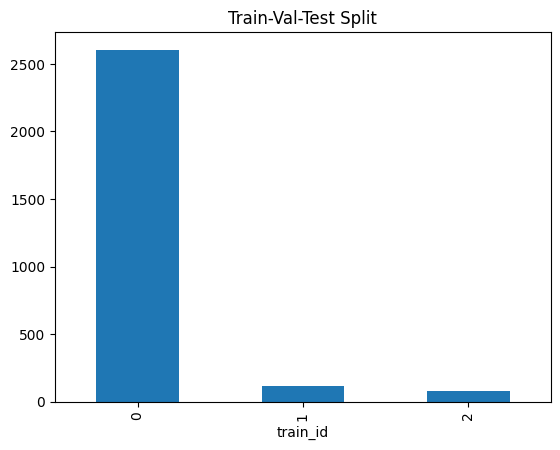

In [14]:
df.train_id.value_counts().plot(kind = 'bar', title = 'Train-Val-Test Split')

In [15]:
import yaml
ppe_data = dict(train = train_path,
                    val = valid_path,
                    test = test_path,
                   nc = len(class_names),
                   names = class_names)
with open('ppe_data.yaml', 'w') as output:
    yaml.dump(ppe_data, output, default_flow_style = True)

yaml_path="/kaggle/working/ppe_data.yaml"

In [30]:
%cat /kaggle/working/ppe_data.yaml

{names: [Hardhat, Mask, NO-Hardhat, NO-Mask, NO-Safety Vest, Person, Safety Cone,
    Safety Vest, machinery, vehicle], nc: 10, test: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test,
  train: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train,
  val: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid}


In [16]:
!pip install -q ultralytics
!pip install -q mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 88.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 71.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.3/788.3 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [17]:
import mlflow 
import dagshub
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
dagshub.init(repo_owner='YassineBen-Yahia',
            repo_name='construction-site-safety',
            mlflow=True)

In [19]:
import mlflow.pytorch
from pathlib import Path


def train_yolo_model(
    model_name='yolov8n.pt',
    epochs=100,
    imgsz=640,
    batch=16,
    optimizer='auto',
    lr0=0.01,
    experiment_name='construction-safety',
    run_name=None
):
    """
    Train a YOLO model with MLflow tracking
    """
    if mlflow.active_run():
        mlflow.end_run()
    # Set MLflow experiment
    mlflow.set_experiment(experiment_name)
    
    # Start MLflow run
    with mlflow.start_run(run_name=run_name or f"{model_name.replace('.pt', '')}_{epochs}ep"):
        
        # Log parameters
        params = {
            'model_name': model_name,
            'epochs': epochs,
            'imgsz': imgsz,
            'batch': batch,
            'optimizer': optimizer,
            'lr0': lr0,
        }
        mlflow.log_params(params)
        
        # Add tags for better organization
        mlflow.set_tag("model_variant", model_name.replace('.pt', ''))
        mlflow.set_tag("framework", "YOLOv8")
        
        # Initialize YOLO model
        model = YOLO(model_name)
        
        # Custom callback for epoch-level tracking
        def on_train_epoch_end(trainer):
            """Callback to log metrics after each epoch"""
            epoch = trainer.epoch
            metrics = trainer.metrics
            
            # Log training metrics per epoch
            epoch_metrics = {
                'train/box_loss': trainer.loss_items[0] if hasattr(trainer, 'loss_items') else 0,
                'train/cls_loss': trainer.loss_items[1] if hasattr(trainer, 'loss_items') and len(trainer.loss_items) > 1 else 0,
                'train/dfl_loss': trainer.loss_items[2] if hasattr(trainer, 'loss_items') and len(trainer.loss_items) > 2 else 0,
            }
            
            # Log validation metrics if available
            if hasattr(metrics, 'results_dict'):
                results = metrics.results_dict
                epoch_metrics.update({
                    'val/mAP50': results.get('metrics/mAP50(B)', 0),
                    'val/mAP50-95': results.get('metrics/mAP50-95(B)', 0),
                    'val/precision': results.get('metrics/precision(B)', 0),
                    'val/recall': results.get('metrics/recall(B)', 0),
                })
            
            # Log learning rate
            if hasattr(trainer.optimizer, 'param_groups'):
                epoch_metrics['learning_rate'] = trainer.optimizer.param_groups[0]['lr']
            
            # Log all metrics with step (epoch number)
            mlflow.log_metrics(epoch_metrics, step=epoch)
            
            print(f"Epoch {epoch}: Logged metrics to MLflow/DagShub")
        
        # Add callback to model
        model.add_callback("on_train_epoch_end", on_train_epoch_end)
        
        # Train the model
        results = model.train(
            data=yaml_path,
            epochs=epochs,
            imgsz=imgsz,
            batch=batch,
            optimizer=optimizer,
            lr0=lr0,
            project='runs/train',
            name=run_name or model_name.replace('.pt', ''),
            save=True,
            save_period=10,
            plots=True,
            verbose=True
        )
        
        # Get best model path
        best_model_path = Path(model.trainer.save_dir) / 'weights' / 'best.pt'
        last_model_path = Path(model.trainer.save_dir) / 'weights' / 'last.pt'
        
        # Log final summary metrics
        metrics_file = Path(model.trainer.save_dir) / 'results.csv'
        if metrics_file.exists():
            import pandas as pd
            df = pd.read_csv(metrics_file)
            df.columns = df.columns.str.strip()
            
            # Log best metrics (not just final)
            if 'metrics/mAP50-95(B)' in df.columns:
                best_epoch = df['metrics/mAP50-95(B)'].idxmax()
                best_metrics = {
                    'best/mAP50': df['metrics/mAP50(B)'].iloc[best_epoch],
                    'best/mAP50-95': df['metrics/mAP50-95(B)'].iloc[best_epoch],
                    'best/precision': df['metrics/precision(B)'].iloc[best_epoch],
                    'best/recall': df['metrics/recall(B)'].iloc[best_epoch],
                    'best/epoch': best_epoch,
                }
                mlflow.log_metrics(best_metrics)
            
            # Also log final metrics
            final_metrics = {
                'final/mAP50': df['metrics/mAP50(B)'].iloc[-1] if 'metrics/mAP50(B)' in df.columns else 0,
                'final/mAP50-95': df['metrics/mAP50-95(B)'].iloc[-1] if 'metrics/mAP50-95(B)' in df.columns else 0,
                'final/precision': df['metrics/precision(B)'].iloc[-1] if 'metrics/precision(B)' in df.columns else 0,
                'final/recall': df['metrics/recall(B)'].iloc[-1] if 'metrics/recall(B)' in df.columns else 0,
            }
            mlflow.log_metrics(final_metrics)
        
        # Log model artifacts
        if best_model_path.exists():
            mlflow.log_artifact(str(best_model_path), 'models')
        if last_model_path.exists():
            mlflow.log_artifact(str(last_model_path), 'models')
        
        # Log ALL training plots
        plots_dir = Path(model.trainer.save_dir)
        plot_patterns = ['*.png', '*.jpg', '*.jpeg']
        for pattern in plot_patterns:
            for plot_file in plots_dir.glob(pattern):
                mlflow.log_artifact(str(plot_file), 'plots')
        
        # Log results CSV for reference
        if metrics_file.exists():
            mlflow.log_artifact(str(metrics_file), 'metrics')
        
        # Log model to MLflow Model Registry
        try:
            mlflow.pytorch.log_model(
                pytorch_model=best_model,
                artifact_path='best_model',
                registered_model_name=f"yolo-construction-safety-{model_name.replace('.pt', '')}"
            )
        except Exception as e:
            print(f"Warning: Could not register model: {e}")
        
 
        print(f" MLflow tracking URI: {mlflow.get_tracking_uri()}")
        print(f" Experiment: {experiment_name}")
        print(f" Run ID: {mlflow.active_run().info.run_id}")
        
        return results, best_model_path




In [ ]:

def run_experiments():
    """Run experiments with different YOLO models"""
    
    models_to_test = [
        {'model_name': 'yolov8n.pt', 'batch': 16, 'epochs': 60},  # Nano 
        {'model_name': 'yolov8s.pt', 'batch': 16, 'epochs': 70},  # Small
        {'model_name': 'yolov8m.pt', 'batch': 8, 'epochs': 70},   # Medium
        # {'model_name': 'yolov8l.pt', 'batch': 4, 'epochs': 100},  # Large
        # {'model_name': 'yolov8x.pt', 'batch': 2, 'epochs': 100},  
    ]
    
    for model_config in models_to_test:
        print("\n")
        print(f"Training {model_config['model_name']}")
       
        
        train_yolo_model(
            model_name=model_config['model_name'],
            epochs=model_config['epochs'],
            batch=model_config['batch'],
            imgsz=640,
            optimizer='auto',
            lr0=0.01,
            experiment_name='construction-safety',
            run_name=f"{model_config['model_name'].replace('.pt', '')}_e{model_config['epochs']}_b{model_config['batch']}" 
        )


def compare_models():
    """Compare all models from MLflow"""
    import pandas as pd
    
    # Get all runs from the experiment
    client = mlflow.tracking.MlflowClient()
    experiment = client.get_experiment_by_name('construction-safety')
    
    if experiment:
        runs = client.search_runs(
            experiment_ids=[experiment.experiment_id],
            order_by=["metrics.final_mAP50-95 DESC"]
        )
        
        # Create comparison DataFrame
        comparison_data = []
        for run in runs:
            comparison_data.append({
                'run_id': run.info.run_id,
                'model': run.data.params.get('model_name', 'N/A'),
                'mAP50': run.data.metrics.get('final_mAP50', 0),
                'mAP50-95': run.data.metrics.get('final_mAP50-95', 0),
                'precision': run.data.metrics.get('final_precision', 0),
                'recall': run.data.metrics.get('final_recall', 0),
                'epochs': run.data.params.get('epochs', 0),
                'batch': run.data.params.get('batch', 0),
            })
        
        df = pd.DataFrame(comparison_data)
        print("\n Model Comparison:")
        print(df.to_string(index=False))
        
        # Save comparison
        df.to_csv('model_comparison.csv', index=False)
        print("\n Comparison saved to model_comparison.csv")
        
        return df
    else:
        print("No experiment found!")
        return None




In [ ]:
run_experiments()



Training yolov8m.pt
Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/ppe_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8m_e70_b8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True,

2026/01/25 12:12:28 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2026/01/25 12:12:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
E0000 00:00:1769343150.276944      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769343150.323647      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769343150.710158      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769343150.710187      55 computation_placer.cc:177] computation placer already registered. Please check linkage and 

MLflow: logging run_id(3dbc9b2805fa49c88008f3c672a79612) to https://dagshub.com/YassineBen-Yahia/construction-site-safety.mlflow
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/detect/runs/train/yolov8m_e70_b8
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/70      3.92G      1.561       3.26      1.633        126        640: 100% ━━━━━━━━━━━━ 326/326 2.3it/s 2:24<0.5s
Epoch 0: Logged metrics to MLflow/DagShub
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 3.2it/s 2.5s0.3ss
                   all        114        697      0.287      0.206      0.227      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/70      4.66G      1.262      1.879      1.435        133        640: 100% ━━━━━━━━━━━━ 326/326 2.6it/s 

In [ ]:
compare_models()